<a href="https://colab.research.google.com/github/ugnet/Faster-RCNN/blob/main/Faster_RCNN_pytorch_RPN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import csv
from skimage.io import imread_collection
import os
from csv import reader
import pandas as pd
import copy

NOT_FOUND = "not_found"
CLASS_BEE = "/m/01h3n"
CLASS_FRUIT = "/m/02xwb"
CLASS_SEAFOOD = "/m/06nwz"
label_types = [CLASS_BEE, CLASS_FRUIT, CLASS_SEAFOOD]

#csv file paths
test_csv_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/csv_folder/test-annotations-bbox.csv'
train_csv_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/csv_folder/train-annotations-bbox.csv'
validate_csv_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/csv_folder/validation-annotations-bbox.csv'

TEST_BEE_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee"
TEST_FRUIT_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Fruit"
TEST_SEAFOOD_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Seafood"

TRAIN_BEE_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/train/Bee"
TRAIN_FRUIT_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/train/Fruit"
TRAIN_SEAFOOD_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/train/Seafood"

test_image_paths = [TEST_BEE_IMAGES, TEST_FRUIT_IMAGES, TEST_SEAFOOD_IMAGES]
train_image_paths = [TRAIN_BEE_IMAGES, TRAIN_FRUIT_IMAGES, TRAIN_SEAFOOD_IMAGES]

TEST_PURPOSE = "test"
TRAIN_PURPOSE = "train"

root_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee'

#your path 
bee_images_dir = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee/*.jpg'
bee_images = imread_collection(bee_images_dir)

ISIZE = (800, 800)

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# our module
class FasterRCNN(nn.Module):
  def __init__(self):
    super.__init__()
    self.vgg = VGG16()


class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

class FasterRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 128, 3)
        # self.linear = nn.Linear(256, 2)
        self.linear = MyLinearLayer(256, 2)

    def forward(self, x):
        x = self. conv(x)
        x = x.view(-1, 256)
        return self.linear(x)

class RPNLayer(nn.Module): #layer
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.
        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        # initialize weights and biases
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) # weight init
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)  # bias init

    def forward(self, feature_map):
        feature_map = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  # w times x + b

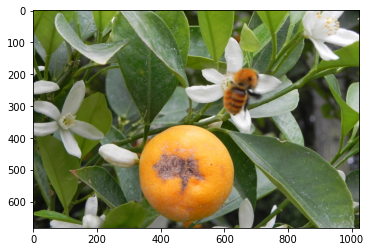

(683, 1024, 3)
the shape of loaded image transformed into numpy array: (683, 1024, 3)
transformed image: [[[ 14 134  99]
  [ 15 135 100]
  [ 15 135 100]
  ...
  [ 23  37  31]
  [ 23  37  31]
  [ 24  38  32]]

 [[ 14 134  99]
  [ 15 135 100]
  [ 15 135 100]
  ...
  [ 24  38  32]
  [ 24  38  32]
  [ 24  38  32]]

 [[ 16 133 100]
  [ 17 134 101]
  [ 15 135 101]
  ...
  [ 25  40  32]
  [ 25  40  32]
  [ 25  40  32]]

 ...

 [[ 24  26  26]
  [ 26  28  28]
  [ 30  32  32]
  ...
  [ 23  56  42]
  [ 24  56  45]
  [ 26  58  47]]

 [[ 24  26  26]
  [ 26  28  28]
  [ 29  31  31]
  ...
  [ 26  59  45]
  [ 27  59  48]
  [ 29  61  50]]

 [[ 24  26  26]
  [ 26  28  28]
  [ 28  30  30]
  ...
  [ 29  62  48]
  [ 30  62  51]
  [ 32  64  53]]]
siiize torch.Size([1, 3, 800, 800])


In [3]:
import torch

#image = cv2.imread('/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee/000e4e7ed48c932d.jpg')

def get_image(path):
  return cv2.imread(path)

def display_image(image):
  img_cvt=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(img_cvt)
  plt.show()


image = get_image('/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee/000e4e7ed48c932d.jpg')
display_image(image)
# image = torch.zeros((1, 3, 800, 800)).float()
# print(image)

# transform Image into the numpy array
image_2_npArray = np.asarray(image)
print(np.shape(image_2_npArray))
print('the shape of loaded image transformed into numpy array: {}'.format(np.shape(image_2_npArray)))
print('transformed image: {}'.format(image_2_npArray))

# transform the numpy array into the tensor
image = torchvision.transforms.ToTensor()(image_2_npArray)
# add one more dimension
image = image.unsqueeze(0)


#resize
image = F.interpolate(image, 800)
print('siiize', image.shape)
#print('transformed numpy array: {}'.format(tensor))
# tensor = torch.reshape(tensor, (1, 3, 800, 800))
# print(tensor.shape())

In [4]:
img = Image.open('/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee/000e4e7ed48c932d.jpg').convert("RGB")
img = img.resize(ISIZE)
img = np.array(img)
img = normalize(img)
img = img.transpose(2,0,1)
img = torch.as_tensor(img, dtype=torch.float32)
img = img.unsqueeze(0)
print(img)

img_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee/000e4e7ed48c932d.jpg'
image = cv2.imread(img_path)
image_2_npArray = np.asarray(image)
image = torchvision.transforms.ToTensor()(image_2_npArray)
image = image.unsqueeze(0)
img = F.interpolate(image, 800)
print(img)

NameError: ignored

In [5]:
  img = cv2.imread('/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee/000e4e7ed48c932d.jpg')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#[595.508224, 181.938906, 719.030272, 345.572046]
  show_img = img
show_image_boxes(torch.from_numpy(show_img), [{'boxes': [[ 26.5775,   0.8509, 320.0000, 167.2844], [ 40.3254,  23.8104, 210.3828, 160.8308]]}])

NameError: ignored

In [6]:
model = torchvision.models.vgg16(pretrained=True)
fe = list(model.features)

req_features = []
k = image.clone()
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]

print(len(req_features)) #30
print(out_channels) # 512

faster_rcnn_fe_extractor = nn.Sequential(*req_features)

feature_map = faster_rcnn_fe_extractor(image)
vizualize_feature_maps(feature_map, 10)
print(feature_map.size())



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



30
512


NameError: ignored

# **Load datasets**

In [16]:
#Imagenet statistics
imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])

## Anchor Box Specs
ratios = [0.5, 1, 2]
anchor_scales = [8, 16, 32]

def normalize(im):
    #im = im.astype(np.float32)/255.
    im = im/255.
    """Normalizes images with Imagenet stats."""
    return (im - imagenet_stats[0])/imagenet_stats[1] 

#function for vizualizing feature maps
def vizualize_feature_maps(feature_map, r):
  imgArray = feature_map.data.cpu().numpy().squeeze(0)
  fig=plt.figure(figsize=(12, 4))
  figNo=1
  for i in range(r):
    fig.add_subplot(1, r, figNo)
    plt.imshow(imgArray[i],  cmap='gray')
    figNo+=1
  plt.show()

#how to update boxes?
class MyDataset(object):
  def __init__(self):
    self.list_of_items = []
    #cia sitam metode turetu buti uzloadinami duomenys

  def __getitem__(self, index):
    item = self.list_of_items[index]
    img_path = item.path
    img = Image.open(img_path).convert("RGB")
    img = img.resize(ISIZE)
    img = np.array(img)
    img = normalize(img)
    img = img.transpose(2,0,1)
    img = torch.as_tensor(img, dtype=torch.float32)
    img = img.unsqueeze(0)

    # img = Image.open(img_path).convert("RGB")
    # img = img.resize(ISIZE)
    # img = np.array(img)
    # img = normalize(img)
    # img = img.transpose(2,0,1)
    # img = torch.as_tensor(img, dtype=torch.float32)

    # convert everything into a torch.Tensor
    boxes = torch.as_tensor(item.box_coordinates, dtype=torch.float32)
    # there is only one class
    # labels = torch.as_tensor(item.labels, dtype=torch.int64)
    # image_id = torch.tensor([item.id])

    # target = {}
    # target["boxes"] = boxes
    # target["labels"] = labels
    # target["image_id"] = image_id
    #target["path"] = item.path

    item_data = {'image': img, 'boxes': boxes, 'labels': item.labels}

    #permute
    #sample['img'] = sample['img'].permute(2, 0, 1)

    return item_data

  def getItemById(self, image_name):
    if ( len(self.list_of_items) == 0):
      return NOT_FOUND
    for item in self.list_of_items:
      if (item.id == image_name):
        return item
    return NOT_FOUND

  def __len__(self):
    return len(self.list_of_items)

  def addItem(self, item):
    self.list_of_items = np.append(self.list_of_items, item)

  def addBoxToItem(self, id, coordinate, label):
    item = self.getItemById(id)
    item.addBox(coordinate, label)

class Item(object):
  def __init__(self, id, name, path):
    super(Item).__init__()
    self.id = id
    self.name = name
    self.path = path
    self.labels = []
    self.box_coordinates = []

  def getBoxes(self):
    return self.box_coordinates

  def addBox(self, coordonates, label):
    self.box_coordinates.append(coordonates)
    self.labels.append(label)

def getImageFileNamesFromPath(directory):
  image_full_file_paths = []
  image_file_names = []

#problema cia su path
#NEGRAZINA image_full_file_paths!! BET IR NENAUDOJAM
  for path in os.listdir(directory):
      full_path = os.path.join(directory, path)
      file_name = os.path.splitext(path)[0]
      image_file_names = np.append(image_file_names, file_name)
      if os.path.isfile(path):
        image_full_file_paths = np.append(image_full_file_paths, full_path)

  return [image_full_file_paths, image_file_names]

#paduodame atrinktas csv failo eilutes turincias tik bbox'us mus dominancioms klasems
def createDataset(purpose, csv_rows):
  dataset = MyDataset()
  for row in csv_rows:
    id = row[0] #also id
    img_name = id + ".jpg"
    label = row[2]
    labels = []
    labels.append(row[2])
    image_path = getRootPath(label, purpose) + '/' + img_name
    # if (item_class == CLASS_BEE):
    #   image_path = root_path + img_name
    img = cv2.imread(image_path)
      #print(img)  #none 
    height, width = img.shape[:2]
    coordinate = [row[4]*800, row[6]*800, row[5]*800, row[7]*800]
    box_coordinates = []
    box_coordinates.append(coordinate)

    if (dataset.getItemById(id) == NOT_FOUND):
      #print("PRIDEJOOM")
      item = Item(id, img_name, image_path)
      item.addBox(coordinate, label)
      dataset.addItem(item)
      continue
    else:
      #print("JAU TUREJO")
      dataset.addBoxToItem(id, coordinate, label)

  return dataset

#is sio metodo gaunamas rows paduadame kurdami dataseta
def filterCsvRows(imageDirPaths, csv_file):
  imageFileNames = []
  for path in imageDirPaths:
    full, notfull = getImageFileNamesFromPath(path)
    imageFileNames = np.concatenate((imageFileNames, notfull))
  filteredRows = csv_file[(csv_file.LabelName.isin(label_types)) & (csv_file.ImageID.isin(imageFileNames))]
  filteredRows = filteredRows.values
  return filteredRows;

def getRootPath(class_name, purpose):
  if (class_name == CLASS_BEE and purpose == TEST_PURPOSE):
    return TEST_BEE_IMAGES
  elif (class_name == CLASS_BEE and purpose == TRAIN_PURPOSE):
    return TRAIN_BEE_IMAGES
  elif (class_name == CLASS_FRUIT and purpose == TEST_PURPOSE):
    return TEST_FRUIT_IMAGES
  elif (class_name == CLASS_FRUIT and purpose == TRAIN_PURPOSE):
    return TRAIN_FRUIT_IMAGES
  elif (class_name == CLASS_SEAFOOD and purpose == TEST_PURPOSE):
    return TEST_SEAFOOD_IMAGES
  elif (class_name == CLASS_SEAFOOD and purpose == TRAIN_PURPOSE):
    return TRAIN_SEAFOOD_IMAGES
  else:
    return NOT_FOUND



In [14]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=3)
   
def show_corner_bbs(im, bbs):
    #im = np.asarray(im).astype(int).transpose(1,2,0)
    im = np.asarray(im).transpose(1,2,0)
    im = unnormalize(im)
    plt.imshow(im)
    for bb in bbs:
        plt.gca().add_patch(create_corner_rect(bb))  

def unnormalize(im):
    im = im.astype(np.float32)
    """Normalizes images with Imagenet stats."""
    im = (im *imagenet_stats[1] +  imagenet_stats[0])*255.
    im = im.astype(np.int)
    return im

In [7]:
item = dataset.__getitem__(5)
image = item["image"]
image = image.squeeze(0)
boxes = item["boxes"]
show_corner_bbs(image, boxes)

NameError: ignored

In [13]:
# 
class RPN(nn.Module):
    
    def __init__(self, in_channels=512, mid_channels=512, n_anchor=9):
        super(RPN, self).__init__()   
        self.mid_channels = mid_channels
        self.in_channels = in_channels # depends on the output feature map. in vgg 16 it is equal to 512
        self.n_anchor = n_anchor # Number of anchors at each location
        self.conv1 = nn.Conv2d(self.in_channels, self.mid_channels, 3, 1, 1)
        self.reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0)
        self.cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0) 
        
        # conv sliding layer
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv1.bias.data.zero_()
        # Regression layer
        self.reg_layer.weight.data.normal_(0, 0.01)
        self.reg_layer.bias.data.zero_()
        # classification layer
        self.cls_layer.weight.data.normal_(0, 0.01)
        self.cls_layer.bias.data.zero_()
        
    def forward(self, k):
        bat_num = k.shape[0]
        x = self.conv1(k)
        pred_anchor_locs = self.reg_layer(x)
        pred_cls_scores = self.cls_layer(x)
        
        pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(bat_num, -1, 4)
        pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
        objectness_score = pred_cls_scores.view(bat_num, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(bat_num, -1)
        pred_cls_scores  = pred_cls_scores.view(bat_num, -1, 2)
        
        return pred_anchor_locs, pred_cls_scores, objectness_score

In [26]:
#Main

def prepareData(purpose):
  if (purpose == TEST_PURPOSE):
    #csffile that we will read
    csv_file = pd.read_csv(test_csv_path)
    rows = filterCsvRows(test_image_paths, csv_file)
    dataset = createDataset(TEST_PURPOSE, rows)
    return dataset
  elif (purpose == TRAIN_PURPOSE):
    #csffile that we will read
    csv_file = pd.read_csv(train_csv_path)
    rows = filterCsvRows(train_image_paths, csv_file)
    dataset = createDataset(TRAIN_PURPOSE, rows)
    return dataset
  else:
    return NOT_FOUND

#resize images
#display image with its boxes
def train_model(vgg_req_features, optimizer, epochs, model, data_loader, rpn_lambda=10):
  for epoch in range(epochs):
    model.train()
    total = 0
    sum_loss = 0
    sum_loss_cls = 0
    sum_loss_loc = 0
    i = 0 
    print("Epoch ", epoch)
    print("i  ", i)
    
    for item in data_loader:
      num_batch =  len(item) #grazina 3 bet gal turetu buti 1?
      print(num_batch)
      image_tensor = item['image']
      #nuimam viena dimensija
      image_tensor=image_tensor.squeeze(0)
      #padarom feature_mapsus
      feature_maps = vgg_req_features(image_tensor)
      # print("##############   feature map shape: ", feature_maps.shape) 
      X_FM, Y_FM = feature_maps.shape[2:]
      #print("##############  X_FM, Y_FM: ",  X_FM, Y_FM )


      anchor_locations_all_merge, anchor_labels_all_merge, anchors = bbox_generation(item, X_FM, Y_FM)

      #RPN
      pred_anchor_locs, pred_cls_scores, objectness_score = model(feature_maps)
      # print('pred_anchor_locs', pred_anchor_locs)
      # print('pred_cls_scores', pred_cls_scores)
      # print('objectness_score', objectness_score)

      #NUO CIA NZ KAS VYKSTA

      rpn_loc_all = pred_anchor_locs.view(1,-1,4).squeeze(0)
      rpn_score_all = pred_cls_scores.view(1,-1,2).squeeze(0)
      #print(rpn_loc_all.shape, rpn_score_all.shape)
      gt_rpn_loc_all = torch.from_numpy(anchor_locations_all_merge.astype(np.float32)).view(1,-1,4).squeeze(0)
      gt_rpn_score_all = torch.from_numpy(anchor_labels_all_merge.astype(np.float32)).view(1,-1).squeeze(0)
      # if is_cuda:
      #     gt_rpn_loc_all = gt_rpn_loc_all.cuda()
      #     gt_rpn_score_all = gt_rpn_score_all.cuda()
      #print(rpn_loc_all.shape, rpn_score_all.shape, gt_rpn_loc_all.shape, gt_rpn_score_all.shape)

      #print(rpn_score_all.shape, gt_rpn_score_all.shape)
      rpn_cls_loss_all = F.cross_entropy(rpn_score_all, gt_rpn_score_all.long(), ignore_index = -1)
      #print(rpn_cls_loss_all)
      
      pos_all = gt_rpn_score_all > 0
      mask_all = pos_all.unsqueeze(1).expand_as(rpn_loc_all)
      #print(pos_all.shape, pos_all.unsqueeze(1).shape, rpn_loc_all.shape,  pos_all.unsqueeze(1).expand_as(rpn_loc_all).shape) 
      num_valid_loc_all = 0
      for i, j in enumerate(pos_all):
          if j.item() == True:
              num_valid_loc_all += 1
      #print (num_valid_loc_all)              
      
      mask_loc_preds_all = rpn_loc_all[mask_all].view(-1, 4)
      #print(mask_loc_preds_all.shape)
      mask_loc_targets_all = gt_rpn_loc_all[mask_all].view(-1, 4)
      #print(mask_loc_preds_all.dtype, mask_loc_targets_all.dtype,gt_rpn_loc_all.dtype ) 

      x_all = torch.abs(mask_loc_targets_all - mask_loc_preds_all)
      rpn_loc_loss_all = ((x_all < 1).float() * 0.5 * x_all**2) + ((x_all >= 1).float() * (x_all-0.5))
      #print(rpn_loc_loss_all.sum())            
      
      N_reg_all = (gt_rpn_score_all >0).float().sum()
      rpn_loc_loss_all = rpn_loc_loss_all.sum() / N_reg_all
      rpn_loss_all = rpn_cls_loss_all + (rpn_lambda * rpn_loc_loss_all)
      #print(rpn_cls_loss_all, rpn_loc_loss_all, rpn_loss_all)  

      optimizer.zero_grad()
      rpn_loss_all.backward()
      optimizer.step()
      
      total += num_batch
      sum_loss += rpn_loss_all.item()
      sum_loss_cls += rpn_cls_loss_all.item()
      sum_loss_loc += (rpn_lambda * rpn_loc_loss_all).item()

      i = i+1
      if (i>=2):
        break
    
    train_loss = sum_loss/total
    train_loss_cls = sum_loss_cls/total
    train_loss_loc = sum_loss_loc/total
    if (epoch+1) % 5 == 0:
        torch.save(model.state_dict(), './rpn_%s.pth'%epoch)
    print("train_loss %.3f cls_loss %.3f loc_loss %.3f" % (train_loss, train_loss_cls, train_loss_loc))

  return model


In [11]:
def validate(model, data_loader, vgg_req_features):
    items = [next(iter(data_loader))]
    print(items)

    itm = items
    img  = items[0]["image"]
    bbox = items[0]["boxes"]
    labels = items[0]["labels"]
    print("bbox: ", bbox)
    print("labels: ", labels)
    print(img.shape)
    img = img.squeeze(0)
    img = img.squeeze(0)
    X_IMG, Y_IMG = img.shape[1:]
    
    img_all = [item['image'] for item in items]
    bbox_all = [item['boxes'] for item in items]
    labels_all = [item['labels'] for item in items]

    # show_corner_bbs(img_all[1], bbox_all[1])
    print( bbox_all[0])
    img_all[0] = img_all[0].squeeze(0)
    img_all[0] = img_all[0].squeeze(0)
    show_corner_bbs(img_all[0], bbox_all[0][0])
    
    num_batch =  1
    
    # imgs_torch_all = torch.stack([item for item in images])
    # if is_cuda:
    #     imgs_torch_all = imgs_torch_all.cuda()   
    # k = imgs_torch_all.clone()
    img = img.unsqueeze(0)
    feature_maps = vgg_req_features(img)
    #print("##############   feature map shape: ", k.shape) 
    X_FM, Y_FM = feature_maps.shape[2:]
    anchor_locations_all_merge, anchor_labels_all_merge, anchors = bbox_generation(items[0], X_FM, Y_FM)
    pred_anchor_locs, pred_cls_scores, objectness_score = model(feature_maps)
    print(pred_anchor_locs.shape, pred_cls_scores.shape, objectness_score.shape)
    print(objectness_score[0,1])
    max_score = pred_cls_scores.argmax(1)
    max_ = objectness_score.argmax(1)
    print (max_score)
    print(max_)
    top_bbox = []
    for ind, item in enumerate(max_):
        print(item.item())
        print(pred_anchor_locs[ind,item.item()])
        roi = pred_bbox_to_xywh(pred_anchor_locs[ind], anchors)
        print (roi.shape)
        print("index: %s bbox: %s "%(ind, roi[item]))
        top_bbox.append([roi[item]])
    #plot_imges_with_bboxes(images, bbox_all)   
    plot_imges_with_bboxes(img, top_bbox)

def plot_imges_with_bboxes(imgs, bboxes, col=4):
    num_imgs = len(imgs)
    row = int(np.ceil(float(len(imgs))/col).item())
    print("row: %s"%row)
    print("imgs: ", num_imgs)
    fig = plt.figure(figsize=(2*col,2*row))
    fig.tight_layout()
    for i in range(row):
        for j in range(col):
            ind = i*col + j
            if ind < num_imgs:
                img = imgs[ind]
                bbs = bboxes[ind]
                print("JABJAJSGV", img.shape)
                img = np.asarray(img).transpose(1,2,0)
                img = unnormalize(img)
                ax = fig.add_subplot(row,col,ind+1,xticks=[],yticks=[])
                ax.imshow(img) 
                for bb in bbs:
                    plt.gca().add_patch(create_corner_rect(bb))
            #ax.text(3, 6, ind, fontdict={'weight': 'bold', 'size': 16}, color="y" )
    fig.suptitle("Images")

def pred_bbox_to_xywh(bbox, anchors):
    print("bbox: ", bbox.shape)
    print("anchors: ", anchors.shape)
    anc_height = anchors[:, 2] - anchors[:, 0]
    anc_width = anchors[:, 3] - anchors[:, 1]
    anc_ctr_y = anchors[:, 0] + 0.5 * anc_height
    anc_ctr_x = anchors[:, 1] + 0.5 * anc_width

    bbox_numpy = bbox.detach().cpu().data.numpy()
    dy = bbox_numpy[:, 0::4]
    dx = bbox_numpy[:, 1::4]
    dh = bbox_numpy[:, 2::4]
    dw = bbox_numpy[:, 3::4]
    ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
    ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
    h = np.exp(dh) * anc_height[:, np.newaxis]
    w = np.exp(dw) * anc_width[:, np.newaxis]

    roi = np.zeros(bbox_numpy.shape, dtype=h.dtype)
    roi[:, 0::4] = ctr_y - 0.5 * h
    roi[:, 1::4] = ctr_x - 0.5 * w
    roi[:, 2::4] = ctr_y + 0.5 * h
    roi[:, 3::4] = ctr_x + 0.5 * w

    return roi

[{'image': tensor([[[[[-1.7069, -1.7069, -1.7069,  ..., -1.3987, -1.4158, -1.4158],
           [-1.7240, -1.7069, -1.6727,  ..., -1.3987, -1.3987, -1.3987],
           [-1.7412, -1.7240, -1.7069,  ..., -1.3987, -1.3987, -1.3815],
           ...,
           [ 1.0673,  1.1015,  1.1358,  ..., -2.0665, -2.0494, -2.0494],
           [ 1.0331,  1.0502,  1.0844,  ..., -2.0494, -2.0665, -2.0494],
           [ 0.9817,  1.0159,  1.0331,  ..., -2.0494, -2.0665, -2.0665]],

          [[-1.4755, -1.4755, -1.4755,  ..., -1.2129, -1.2304, -1.2304],
           [-1.4930, -1.4930, -1.5105,  ..., -1.2129, -1.2129, -1.2129],
           [-1.5105, -1.4930, -1.4755,  ..., -1.2129, -1.2129, -1.1954],
           ...,
           [ 1.0805,  1.1331,  1.1681,  ..., -1.9657, -1.9482, -1.9482],
           [ 1.0455,  1.0630,  1.0980,  ..., -1.9482, -1.9657, -1.9482],
           [ 0.9930,  1.0280,  1.0455,  ..., -1.9482, -1.9657, -1.9657]],

          [[-1.6650, -1.6476, -1.6476,  ..., -1.5081, -1.5256, -1.5256],
    

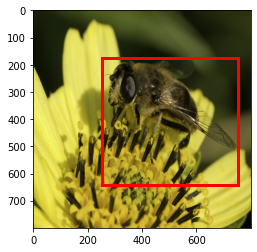

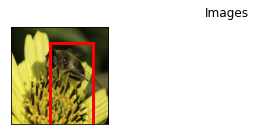

In [31]:
# dataset = prepareData(TEST_PURPOSE)
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)
# model = RPN()
# parameters = model.parameters()
# optimizer = torch.optim.Adam(parameters, lr=0.0015)

# trained_RPN_model = train_model(faster_rcnn_fe_extractor, optimizer, 3, model, data_loader)
# print(model)
validate(model, data_loader, faster_rcnn_fe_extractor)

In [10]:
def bbox_generation(items, X_FM, Y_FM):
    global ratios
    global anchor_scales
    num_batch = 1
    X_IMG, Y_IMG = 800, 800
    bbox_all = items["boxes"]#BLOGAIII ITEM MES NETURIM!!!!!!
    labels_all = items['labels']

    # bbox_all = [item['boxes'] for item in items]
    # labels_all = [item['labels'] for item in items]
    #imgs_torch_all = torch.stack([item for item in images])
    #if is_cuda:
    #    imgs_torch_all = imgs_torch_all.cuda()   
    #k = imgs_torch_all.clone()
    #for m in req_features:
    #    k = m(k)
    #print(k.shape) 
    

    sub_sampling_x = int(X_IMG/X_FM)
    sub_sampling_y = int(Y_IMG/Y_FM)
    #print(X_IMG, Y_IMG, X_FM, Y_FM, sub_sampling_x,sub_sampling_y)
    anchor_base = np.zeros((len(ratios)*len(anchor_scales), 4), dtype=np.float32)

    ctr_x = np.arange(sub_sampling_x, (X_FM+1) * sub_sampling_x, sub_sampling_x)
    ctr_y = np.arange(sub_sampling_y, (Y_FM+1) * sub_sampling_y, sub_sampling_y)
    index = 0
    ctr = np.zeros((len(ctr_y)*len(ctr_y),2),dtype=np.float32)
    for x in range(len(ctr_x)):
        for y in range(len(ctr_y)):
            ctr[index, 1] = ctr_x[x] - 8
            ctr[index, 0] = ctr_y[y] - 8
            index +=1 
            
    anchors = np.zeros((X_FM * Y_FM * 9, 4))
    index = 0
    for ctr_y, ctr_x in ctr:
        for i in range(len(ratios)):
            for j in range(len(anchor_scales)):
                h = sub_sampling_x * anchor_scales[j] * np.sqrt(ratios[i])
                w = sub_sampling_y * anchor_scales[j] * np.sqrt(1./ ratios[i])
                anchors[index, 0] = ctr_y - h / 2.
                anchors[index, 1] = ctr_x - w / 2.
                anchors[index, 2] = ctr_y + h / 2.
                anchors[index, 3] = ctr_x + w / 2.
                index += 1
    #print(anchors.shape)    
    index_inside = np.where(
        (anchors[:, 0] >= 0) &
        (anchors[:, 1] >= 0) &
        (anchors[:, 2] <= Y_IMG) &
        (anchors[:, 3] <= X_IMG)
    )[0]
    #print(index_inside.shape)
    
    label = np.empty((len(index_inside), ), dtype=np.int32)
    label.fill(-1)
    valid_anchors = anchors[index_inside]
    #print(label.shape, valid_anchors.shape)
    #print(valid_anchors[0]

    ious_all = []
    for bx in bbox_all:
        ious = np.empty((len(label), bx.size()[0]), dtype=np.float32)
        ious.fill(0)
        for num1, i in enumerate(valid_anchors):
            ya1, xa1, ya2, xa2 = i  
            anchor_area = (ya2 - ya1) * (xa2 - xa1)
            for num2, j in enumerate(bx):
                yb1, xb1, yb2, xb2 = j
                box_area = (yb2- yb1) * (xb2 - xb1)
                inter_x1 = max([xb1, xa1])
                inter_y1 = max([yb1, ya1])
                inter_x2 = min([xb2, xa2])
                inter_y2 = min([yb2, ya2])
                if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
                    iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
                    iou = iter_area / (anchor_area+ box_area - iter_area)            
                else:
                    iou = 0.
                ious[num1, num2] = iou
        ious_all.append(ious)
        
        
    gt_argmax_ious_all = []
    gt_max_ious_all = []
    for ious_ in ious_all:
        gt_argmax_ious = ious_.argmax(axis=0)
        gt_max_ious = ious_[gt_argmax_ious, np.arange(ious_.shape[1])]
        gt_argmax_ious_all.append(gt_argmax_ious)
        gt_max_ious_all.append(gt_max_ious)
    #print(gt_argmax_ious_all)  
    #print(gt_max_ious_all)   
    argmax_ious_all = []
    max_ious_all = []
    for ious_ in ious_all:
        argmax_ious = ious_.argmax(axis=1)
        max_ious = ious_[np.arange(len(label)), argmax_ious]
        argmax_ious_all.append(argmax_ious)
        max_ious_all.append(max_ious)
    #print(argmax_ious_all)    
    #print(max_ious_all)  
    
    gt_argmax_ious_all = []
    for gt_max_ious_, ious_ in zip(gt_max_ious_all, ious_all):
        gt_argmax_ious = np.where(ious_ == gt_max_ious_)[0]
        gt_argmax_ious_all.append(gt_argmax_ious)
    #print(gt_argmax_ious_all)       

    pos_iou_threshold  = 0.7
    neg_iou_threshold = 0.3  
    
    label_all = []
    for n in range(num_batch):
        l = copy.deepcopy(label)
        l[max_ious_all[n] < neg_iou_threshold] = 0
        l[gt_argmax_ious_all[n]] = 1
        l[max_ious_all[n] >= pos_iou_threshold] = 1
        label_all.append(l)
    #print ("label_all 0 and 1: ", sum(label_all[0]), sum(label_all[1]))     
    
    pos_ratio = 0.5
    n_sample = 256
    n_pos = int(pos_ratio * n_sample)
    #print(n_pos)    
    for n in range(num_batch):
        #print(np.sum((label_all[n] == 1)))
        pos_index = np.where(label_all[n] == 1)[0]
        #print(pos_index)
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
            label_all[n][disable_index] = -1
        #print(np.sum((label_all[n] == 1)))  

        n_neg = n_sample - np.sum(label_all[n] == 1)
        neg_index = np.where(label_all[n] == 0)[0]
        if len(neg_index) > n_neg:
            disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
            label_all[n][disable_index] = -1
        #print(np.sum((label_all[n] == 0)))   
        
        
    max_iou_bbox_all = []
    #print(bbox_all)
    for n in range(num_batch):
        max_iou_bbox_all.append(bbox_all[n][argmax_ious_all[n]])
    #print(max_iou_bbox_all[0].shape, max_iou_bbox_all[0].shape)    
    #Anchor box
    height = valid_anchors[:, 2] - valid_anchors[:, 0]
    width = valid_anchors[:, 3] - valid_anchors[:, 1]
    ctr_y = valid_anchors[:, 0] + 0.5 * height
    ctr_x = valid_anchors[:, 1] + 0.5 * width
    #Ground truth
    base_height_all = []
    base_width_all = []
    base_ctr_y_all = []
    base_ctr_x_all = []
    for n in range(num_batch):
        base_height = max_iou_bbox_all[n][:, 2] - max_iou_bbox_all[n][:, 0]
        base_width = max_iou_bbox_all[n][:, 3] - max_iou_bbox_all[n][:, 1]
        base_ctr_y = max_iou_bbox_all[n][:, 0] + 0.5 * base_height
        base_ctr_x = max_iou_bbox_all[n][:, 1] + 0.5 * base_width
        base_height_all.append(base_height)
        base_width_all.append(base_width)
        base_ctr_y_all.append(base_ctr_y)
        base_ctr_x_all.append(base_ctr_x)

    #print(width[2], base_width_all[0][2])        
        
    #Prevent devide by 0
    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps)
    width = np.maximum(width, eps)

    #d_{} calculatrion
    anchor_locs_all = []
    for n in range(num_batch):
        dy = (base_ctr_y_all[n].numpy() - ctr_y) / height
        dx = (base_ctr_x_all[n].numpy() - ctr_x) / width
        dh = np.log(base_height_all[n].numpy()/ height)
        dw = np.log(base_width_all[n].numpy() / width)
        anchor_locs_all.append(np.vstack((dy, dx,dh, dw)).transpose())
    #print(anchor_locs_all[0][1], anchor_locs_all[0].shape)      
    anchor_labels_all = []
    for n in range(num_batch):
        anchor_labels = np.empty((len(anchors),), dtype=label_all[n].dtype)
        anchor_labels.fill(-1)
        anchor_labels[index_inside] = label_all[n]
        anchor_labels_all.append(anchor_labels)
    anchor_labels_all_merge = np.stack(anchor_labels_all, 0)    
    #print(sum(anchor_labels_all[0]==1), anchor_labels_all[0][0:11])
    #print(anchor_labels_all_merge.shape)
    #print(sum(anchor_labels_all_merge[0]==1))    
    
    anchor_locations_all = []
    for n in range(num_batch):
        anchor_locations = np.empty((len(anchors), anchors.shape[1]), dtype=anchor_locs_all[n].dtype)
        anchor_locations.fill(0)
        anchor_locations[index_inside, :] = anchor_locs_all[n]
        anchor_locations_all.append(anchor_locations)
    #print(anchor_locations_all[0].shape)   
    #print(type(anchor_locations_all[0]))
    anchor_locations_all_merge = np.stack(anchor_locations_all, 0)
    #print(anchor_locations_all_merge[0][0])
    #print(anchor_locations_all[0][1500])    
  
    return anchor_locations_all_merge, anchor_labels_all_merge, anchors